### Segmentation of a blood vessel dataset
To download the dataset, run the following cell:

In [ ]:
from dataset_vessel import download
download(directory='data')

In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import train_vessel
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('data/vessel/images'),
    'label_dir': Path('data/vessel/labels'),      
    'train_val_split': 0.1,
    # Model
    'model_layers': (1, 1, 1), 
    'model_channels': (16,32,64), 
    'model_type': 'unet',
    # Training
    'epochs': 200,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, 
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.3414, 0.6586),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs/',
    'experiment':'unet_l_1_1_1_c_16_32_64',
    'save_every':1,                
    'save_best':True,
    # Other
    'resume': False,
    'meta': None
}

logger, ds_train, ds_valid, model = train_vessel.run(params)

Epoch 1/200
Batch 12/12, Train loss: 0.39060404896736145
Epoch finished in 13.5 seconds
Train loss: 0.8892371661133236, Valid loss: 0.7890360355377197, IoU: 0.6310160160064697, Prec: 0.7265607118606567, Rec 0.8313509225845337
Epoch 2/200
Batch 12/12, Train loss: 0.20186613500118256
Epoch finished in 0.4 seconds
Train loss: 0.3371208002169927, Valid loss: 0.4740171432495117, IoU: 0.6749318838119507, Prec: 0.800216794013977, Rec 0.8140392303466797
Epoch 3/200
Batch 12/12, Train loss: 0.23617510497570038
Epoch finished in 0.4 seconds
Train loss: 0.2602819174528122, Valid loss: 0.3734542429447174, IoU: 0.6635974049568176, Prec: 0.7642625570297241, Rec 0.836216151714325
Epoch 4/200
Batch 12/12, Train loss: 0.23242621123790746
Epoch finished in 0.4 seconds
Train loss: 0.23908046848244138, Valid loss: 0.32594770193099976, IoU: 0.6787177324295044, Prec: 0.7721456289291382, Rec 0.8506783246994019
Epoch 5/200
Batch 12/12, Train loss: 0.19608256220817566
Epoch finished in 0.4 seconds
Train loss: 

### View results

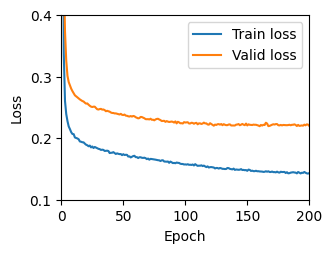

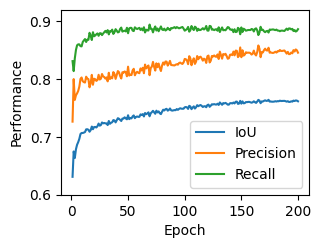

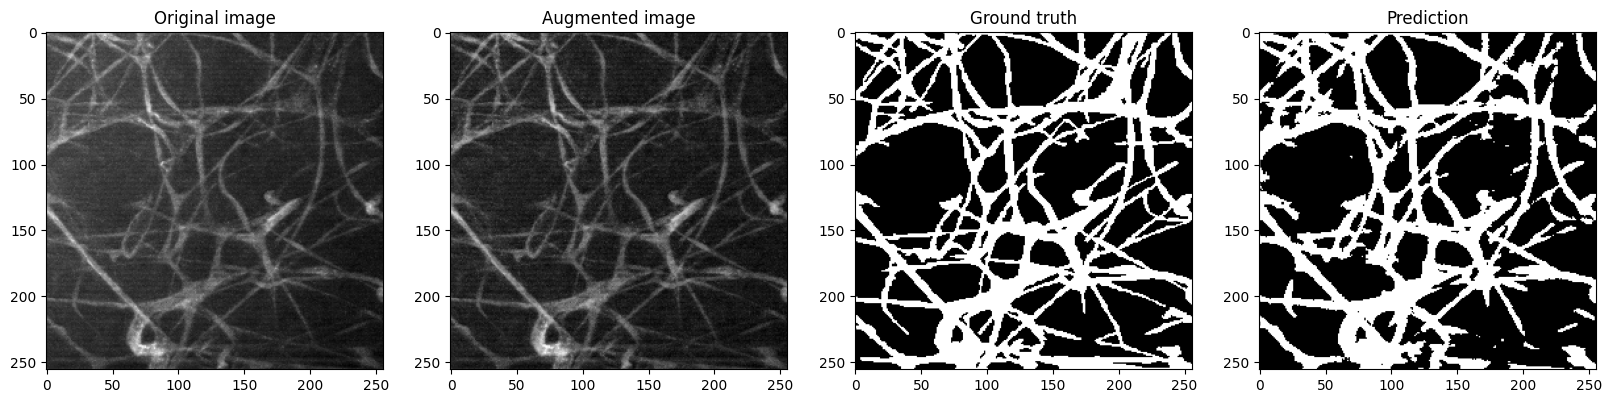

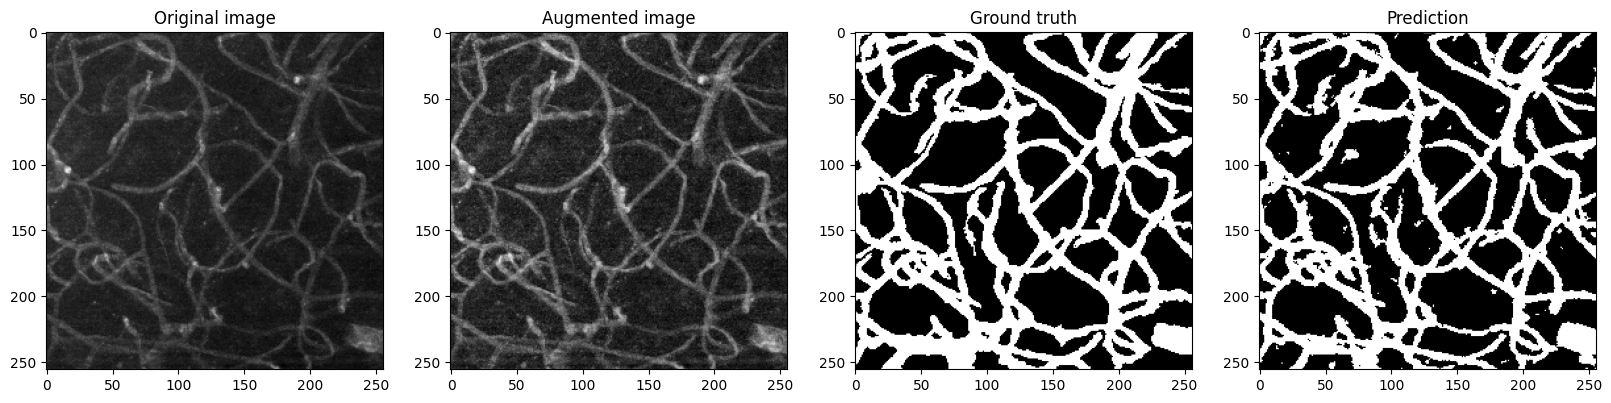

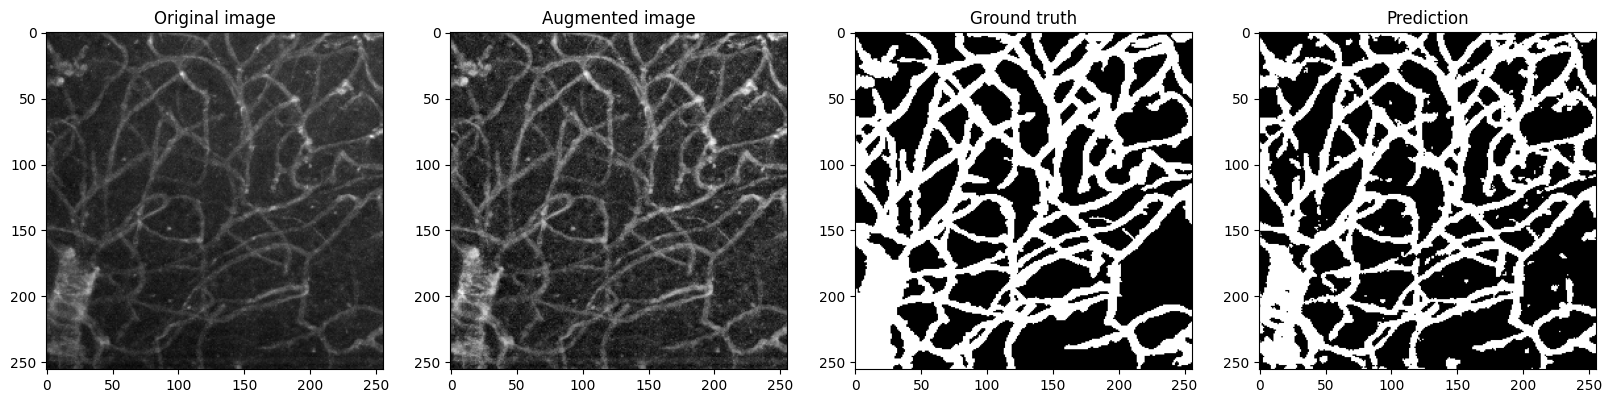

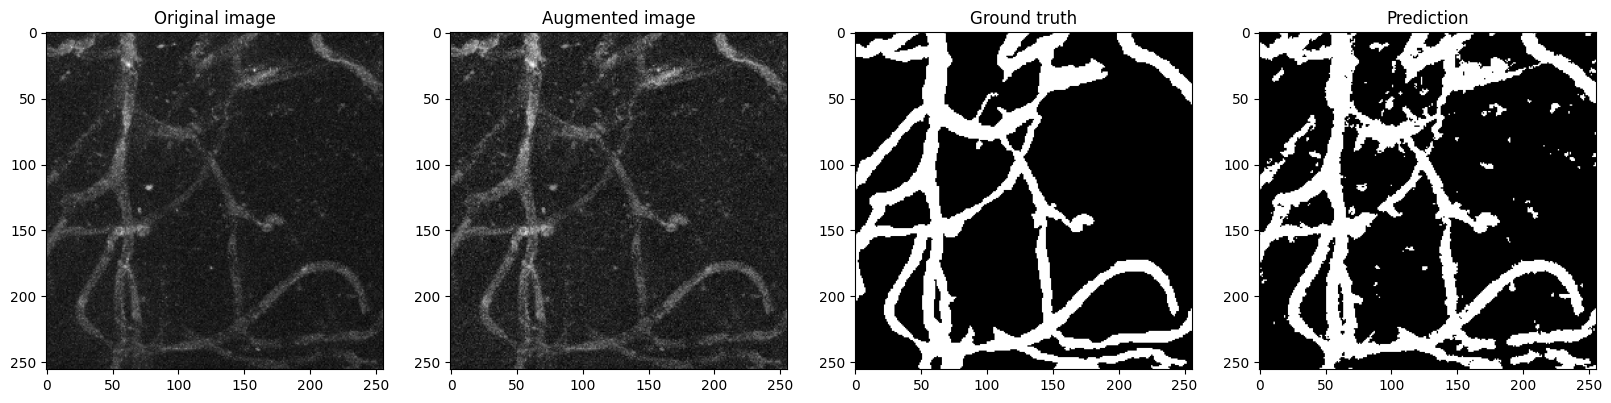

In [5]:
# Plot results
def plot_metrics(logger):
    '''Plot losses and IoU.''' 
    
    epochs, metrics = zip(*logger.data.items())
    train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0.1, 0.4))
    plt.xlim((0, 200))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 0.92))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)  # Randomly draw some indices
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger)
plot_examples(ds_valid, model)

### Analyze model statistics

In [11]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min().item(), output.max().item()))
print('Batch index, min val, max val')
stats

Batch index, min val, max val


[(0, -11.079233169555664, 9.056458473205566),
 (1, -17.234394073486328, 9.686851501464844),
 (2, -24.697473526000977, 10.273669242858887),
 (3, -25.735403060913086, 10.12680721282959),
 (4, -16.97800064086914, 9.193696975708008),
 (5, -18.95757293701172, 9.25354290008545),
 (6, -18.075149536132812, 10.859057426452637),
 (7, -18.080537796020508, 10.37811279296875),
 (8, -20.985992431640625, 12.891106605529785),
 (9, -19.21536636352539, 9.899541854858398)]

In [12]:
# Check performance
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
print('Batch index, batch metrics')
stats

Batch index, batch metrics


[(0,
  ('iou', tensor(0.5424)),
  ('prec', tensor(0.6839)),
  ('rec', tensor(0.7238))),
 (1,
  ('iou', tensor(0.7238)),
  ('prec', tensor(0.8086)),
  ('rec', tensor(0.8735))),
 (2,
  ('iou', tensor(0.7749)),
  ('prec', tensor(0.8468)),
  ('rec', tensor(0.9011))),
 (3,
  ('iou', tensor(0.7543)),
  ('prec', tensor(0.8628)),
  ('rec', tensor(0.8572))),
 (4,
  ('iou', tensor(0.8181)),
  ('prec', tensor(0.9222)),
  ('rec', tensor(0.8788))),
 (5,
  ('iou', tensor(0.7878)),
  ('prec', tensor(0.9213)),
  ('rec', tensor(0.8447))),
 (6,
  ('iou', tensor(0.8713)),
  ('prec', tensor(0.9011)),
  ('rec', tensor(0.9634))),
 (7,
  ('iou', tensor(0.8547)),
  ('prec', tensor(0.8896)),
  ('rec', tensor(0.9561))),
 (8,
  ('iou', tensor(0.6754)),
  ('prec', tensor(0.6964)),
  ('rec', tensor(0.9574))),
 (9,
  ('iou', tensor(0.8069)),
  ('prec', tensor(0.8548)),
  ('rec', tensor(0.9351)))]

In [13]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

[('resunet.conv1', tensor(-4.3367), tensor(5.3345)),
 ('resunet.bn1', tensor(-5.1963), tensor(5.4252)),
 ('resunet.relu', tensor(0.), tensor(5.4252)),
 ('resunet.encoder.stage_0.0.conv1', tensor(-6.4669), tensor(8.2637)),
 ('resunet.encoder.stage_0.0.bn1', tensor(-5.5881), tensor(5.3300)),
 ('resunet.encoder.stage_0.0.relu1', tensor(0.), tensor(5.3300)),
 ('resunet.encoder.stage_0.0.conv2', tensor(-5.7422), tensor(5.4812)),
 ('resunet.encoder.stage_0.0.bn2', tensor(-5.1316), tensor(5.1627)),
 ('resunet.encoder.stage_0.0.relu2', tensor(0.), tensor(8.0863)),
 ('resunet.encoder.stage_0.0.downsample.0', tensor(-4.6641), tensor(7.3100)),
 ('resunet.encoder.stage_0.0.downsample.1', tensor(-5.3934), tensor(6.8335)),
 ('resunet.encoder.stage_0.0.downsample', tensor(-5.3934), tensor(6.8335)),
 ('resunet.encoder.stage_0.0', tensor(0.), tensor(8.0863)),
 ('resunet.encoder.stage_0', tensor(0.), tensor(8.0863)),
 ('resunet.encoder.stage_1.0.conv1', tensor(-6.2859), tensor(5.3366)),
 ('resunet.encod

In [14]:
# Benchmark model

model = torchtrainer.models.resunet.ResUNet((1,1,1), (16,32,64))
tensor_shape = (8, 1, 256, 256)
stats_train = torchtrainer.profiling.benchmark_model(model, tensor_shape, no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
stats_val = torchtrainer.profiling.benchmark_model(model, tensor_shape, no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
print(stats_train)
print(stats_val)

{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.38027381896972656, 'time_cpu': 0.01899886131286621, 'time_gpu': 0.01658470344543457, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.16246509552001953, 'time_cpu': 0.005001544952392578, 'time_gpu': 0.006260735988616943, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
